In [2]:
pip install coremltools

     -------------------------------------- 882.2/882.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Created wheel for coremltools: filename=coremltools-6.1-py3-none-any.whl size=1181394 sha256=df65bb4cfeb46cdff85b6abbc8e05a6cee5ebc536aa94463669b84300e591751
  Stored in directory: c:\users\fifid\appdata\local\pip\cache\wheels\99\ee\ce\eefc6b284a2999bd688ec5663be3c2dc367a306cf23bb15d87
Successfully built coremltools


In [7]:
pip install keras_preprocessing livelossplot


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import pandas as pd
import string
import random
import matplotlib
import numpy as np
#import coremltools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from keras import backend as K
from ast import literal_eval
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from livelossplot import PlotLossesKeras
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

In [2]:
import PIL
import os
import os.path
from PIL import Image

f = r'Ressources_Test\images'
for file in os.listdir(f):
    f_img = f+"/"+file
    img = Image.open(f_img)
    img = img.resize((224,224))
    img.save(f_img)

In [3]:
# Download dataset from https://www.kaggle.com/greg115/various-tagged-images
DATASET_PATH = 'Ressources_Test\images' # Directory of the images with the following format "id-tag1_tag2.jpg"
METADATA_PATH = 'Ressources_Test\img_attributes.csv' #modif
IMAGE_PATH_KEY = "image_path"
TAGS_PATH_KEY = "tags"
MODEL_PATH = "image_tagger.h5"
IMAGE_SIZE = 224 # pas modif car sinon pb avec fully connected
BATCH_SIZE = 16 #nb d'images en entrée du réseau en même temps
TESTING_SIZE = 500 #modif
VALIDATION_SPLIT = 0.01 # a modif
RANDOM_SEED = 115
EPOCHS = 20 #combien de fois on visualise l'ensemble des images du dataset, au moins 100
DROPOUT = 0.5 #0.2 ou 0.3
FULLY_CONNECTED = 1024
LEARNING_RATE = 0.0001
LEARNING_RATE_DECAY = LEARNING_RATE/100.0
CONFIDENCE_THRESHOLD = 0.9

In [4]:
# Loading metadata and splitting into training/validation and testing sets
df_old = pd.read_csv(METADATA_PATH)
#print(list(df[df.columns[0]]))

y = []
for row in df_old.iterrows():

    sub_y = []
    for i in range(1,len(row[1])) :
        if (int(row[1][i])==1):
            sub_y.append(df_old.columns.values[i])
    y.append(sub_y)
    
#print(y)
df = pd.DataFrame(list(zip(list(df_old[df_old.columns[0]]), y)),
               columns =['image_path', 'tags'])
print(df)
print(df.shape[0])

     image_path                                               tags
0    000001.jpg  [Arched_Eyebrows, Attractive, Brown_Hair, Heav...
1    000002.jpg  [Bags_Under_Eyes, Big_Nose, Brown_Hair, High_C...
2    000003.jpg  [Big_Lips, Blurry, Male, Narrow_Eyes, No_Beard...
3    000004.jpg  [Attractive, No_Beard, Pointy_Nose, Straight_H...
4    000005.jpg  [Arched_Eyebrows, Attractive, Big_Lips, Heavy_...
..          ...                                                ...
995  000996.jpg  [Arched_Eyebrows, Bangs, Blond_Hair, Heavy_Mak...
996  000997.jpg  [Attractive, Bangs, Blond_Hair, Heavy_Makeup, ...
997  000998.jpg  [Arched_Eyebrows, Attractive, Blond_Hair, Heav...
998  000999.jpg                                   [Male, No_Beard]
999  001000.jpg  [Attractive, Big_Lips, Heavy_Makeup, High_Chee...

[1000 rows x 2 columns]
1000


In [28]:


training_and_validation_size = df.shape[0] - TESTING_SIZE

print(training_and_validation_size)

training_df = df[:training_and_validation_size]
testing_df = df[training_and_validation_size:]

#training_df[TAGS_PATH_KEY] = training_df[TAGS_PATH_KEY].apply(lambda x:literal_eval(x))
training_df
testing_df

500


,image_path,tags
500,000501.jpg,"[Attractive, Bags_Under_Eyes, High_Cheekbones,..."
501,000502.jpg,"[Arched_Eyebrows, Attractive, Big_Lips, Black_..."
502,000503.jpg,"[Arched_Eyebrows, Attractive, Big_Lips, Blond_..."
503,000504.jpg,"[Attractive, Bags_Under_Eyes, Brown_Hair, Bush..."
504,000505.jpg,"[Black_Hair, Chubby, High_Cheekbones, No_Beard..."
...,...,...
995,000996.jpg,"[Arched_Eyebrows, Bangs, Blond_Hair, Heavy_Mak..."
996,000997.jpg,"[Attractive, Bangs, Blond_Hair, Heavy_Makeup, ..."
997,000998.jpg,"[Arched_Eyebrows, Attractive, Blond_Hair, Heav..."
998,000999.jpg,"[Male, No_Beard]"


In [6]:
# Getting labels
all_labels = [] 

for tags in training_df[TAGS_PATH_KEY].values.tolist():
    for tag in tags:
        all_labels.append(tag)
        
#unique_labels = list(df_old.columns.values[1:])
unique_labels = list(np.unique(all_labels))


In [7]:
#print(unique_labels)
#print(all_labels)
print(type(unique_labels))
print(type(all_labels))
print(type(unique_labels[0]))
print(type(all_labels[0]))

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
['Arched_Eyebrows', 'Attractive', 'Brown_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Mouth_Slightly_Open', 'No_Beard', 'Pointy_Nose', 'Smiling', 'Straight_Hair', 'Wearing_Earrings', 'Wearing_Lipstick', 'Young', 'Bags_Under_Eyes', 'Big_Nose', 'Brown_Hair', 'High_Cheekbones', 'Mouth_Slightly_Open', 'No_Beard', 'Smiling', 'Young', 'Big_Lips', 'Blurry', 'Male', 'Narrow_Eyes', 'No_Beard', 'Pointy_Nose', 'Wavy_Hair', '

In [9]:
training_data_generator = ImageDataGenerator(rotation_range=30,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             shear_range=0.2,
                                             horizontal_flip=True,
                                             fill_mode="nearest",
                                             validation_split=VALIDATION_SPLIT,
                                             preprocessing_function=preprocess_input)

training_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                 directory=DATASET_PATH,
                                                                 x_col=IMAGE_PATH_KEY, 
                                                                 y_col=TAGS_PATH_KEY,
                                                                 batch_size=BATCH_SIZE,
                                                                 seed=RANDOM_SEED,
                                                                 class_mode="categorical",
                                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                                 subset="training")

validation_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                   directory=DATASET_PATH,
                                                                   x_col=IMAGE_PATH_KEY,
                                                                   y_col=TAGS_PATH_KEY,
                                                                   batch_size=BATCH_SIZE,
                                                                   seed=RANDOM_SEED,
                                                                   class_mode="categorical",
                                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                                   subset="validation")



Found 495 validated image filenames belonging to 40 classes.
Found 5 validated image filenames belonging to 40 classes.


In [10]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p++K.epsilon()))

def get_model():
    def model(backbone):
        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(Dropout(DROPOUT))
        model.add(BatchNormalization())
        model.add(Dense(FULLY_CONNECTED, activation='relu'))
        model.add(Dense(len(unique_labels), activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizers.Adam(lr=LEARNING_RATE, decay=LEARNING_RATE_DECAY),
                      metrics=["accuracy", recall, precision, f1])
        return model

    backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
    backbone.trainable = False
    return model(backbone)

model = get_model()

C:\Users\fifid\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
# Setting class weights to handle imbalanced data
class_weights = class_weight.compute_class_weight('balanced',
                                                  unique_labels,
                                                  all_labels)

print(class_weights)

C:\Users\fifid\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'], y=['Arched_Eyebrows', 'Attractive', 'Brown_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Mouth_Slightly_Open', 'No_Beard', 'Pointy_Nose', 'Smiling', 'Straight_Hair', 'Wearing_Earrings', 'Wearing_Lipstick', 'Young', 'Bags_Under_Eyes', 'Big_Nose', 'Brown_Hair', 'High_Cheekbones', 'Mouth_Slightly_Open', 'No_Beard', 

[1.86008065 0.80646853 0.44017176 1.0879717  8.87115385 1.51743421
 0.90097656 0.90097656 0.90097656 1.62429577 5.49166667 1.0879717
 1.49772727 3.20347222 4.2712963  3.72016129 3.49469697 4.613
 0.59141026 0.51484375 0.52183258 0.44873541 6.78382353 1.86008065
 0.28616625 0.88034351 4.80520833 0.78989726 3.11689189 3.03486842
 3.84416667 0.47071429 1.01162281 0.78452381 1.18891753 4.2712963
 0.49709052 1.57979452 2.62102273 0.30671543]


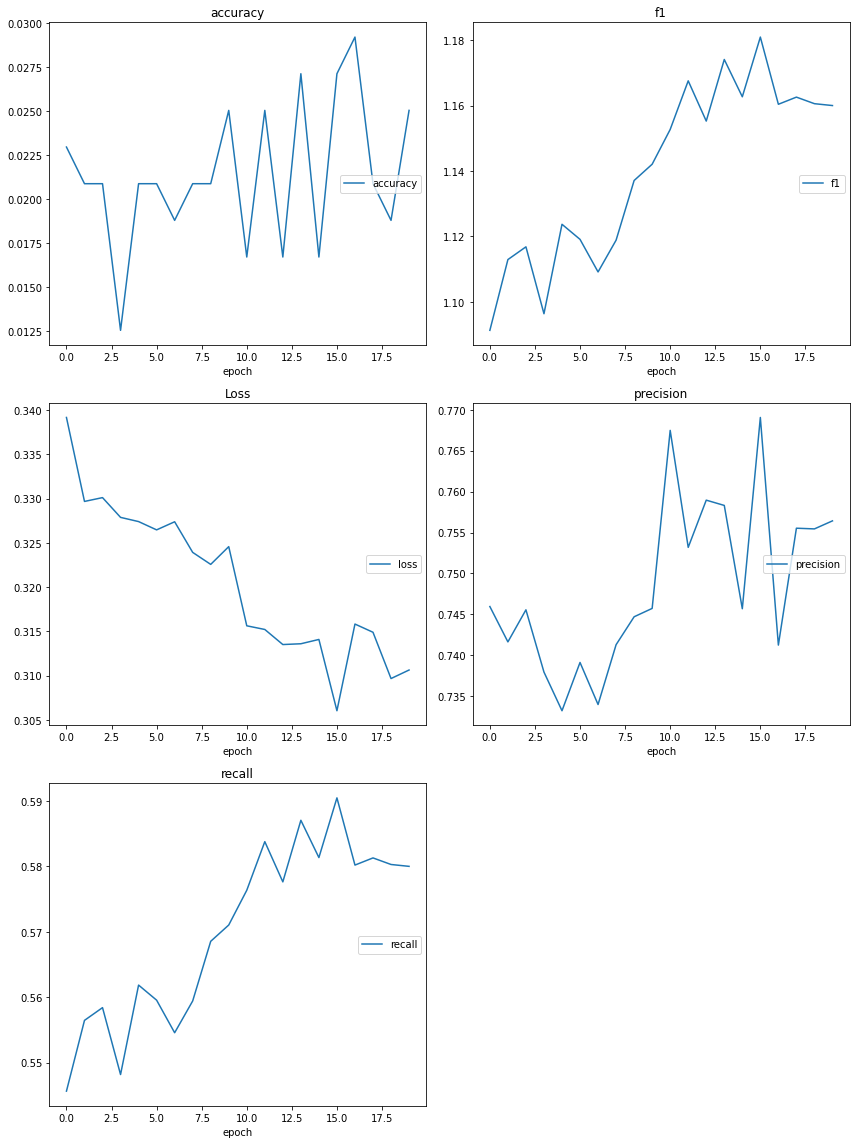

accuracy
	accuracy         	 (min:    0.013, max:    0.029, cur:    0.025)
f1
	f1               	 (min:    1.091, max:    1.181, cur:    1.160)
Loss
	loss             	 (min:    0.306, max:    0.339, cur:    0.311)
precision
	precision        	 (min:    0.733, max:    0.769, cur:    0.756)
recall
	recall           	 (min:    0.546, max:    0.590, cur:    0.580)
30/30 [==============================] - 9s 297ms/step - loss: 0.3106 - accuracy: 0.0251 - recall: 0.5800 - precision: 0.7564 - f1: 1.1600


In [18]:
# Training
model.fit(x=training_generator,
                  
                    steps_per_epoch=training_generator.n // training_generator.batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[PlotLossesKeras(), 
                               ModelCheckpoint(MODEL_PATH,
                                               monitor='val_f1',
                                               mode='max',
                                               save_best_only=True,
                                               verbose=1)],
                    epochs=EPOCHS)
#model = load_model(MODEL_PATH, custom_objects={"f1": f1, "recall": recall,"precision": precision})

In [19]:
# Testing
testing_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
testing_generator = testing_data_generator.flow_from_dataframe(dataframe=testing_df,
                                                               directory=DATASET_PATH,
                                                               x_col=IMAGE_PATH_KEY,
                                                               batch_size=1,
                                                               seed=RANDOM_SEED,
                                                               shuffle=False,
                                                               class_mode=None,
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE))
predictions = model.predict(testing_generator,
                                      steps=TESTING_SIZE,
                                      verbose=1)

Found 500 validated image filenames.
500/500 [==============================] - 14s 28ms/step


In [43]:
def show_images(images, titles, rows):
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        subplot = fig.add_subplot(rows, np.ceil(len(images)/float(rows)), n + 1)
        plt.imshow(image)
        subplot.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * len(images))
    plt.savefig("results.png", bbox_inches="tight", pad_inches=0)
    plt.show()
    plt.close()
    
images = []
images_path = []
titles = []

top_n = 40

for prediction_index, prediction in enumerate(predictions):
    title = []
    top_n_indices = np.argpartition(prediction, -top_n)[-top_n:]
    for top_n_index in top_n_indices:
        if prediction[top_n_index]*100 >40 :
            title.append(unique_labels[top_n_index] + " %.1f" % (prediction[top_n_index]*100) + "%")
            
    image_path = DATASET_PATH + '/' + testing_generator.filenames[prediction_index]
    img = mpimg.imread(image_path)
    images_path.append(image_path)
    images.append(img)
    titles.append(title)
#show_images(images, titles, len(images))

In [45]:

print(images_path[2])
tit = titles[2]
tit.sort()
print(tit)

Ressources_Test\images/000503.jpg
['Arched_Eyebrows 74.9%', 'Attractive 94.7%', 'Blond_Hair 57.0%', 'Bushy_Eyebrows 47.4%', 'Heavy_Makeup 79.9%', 'High_Cheekbones 53.3%', 'Mouth_Slightly_Open 66.6%', 'No_Beard 99.1%', 'Oval_Face 73.3%', 'Smiling 56.8%', 'Wearing_Earrings 68.3%', 'Wearing_Lipstick 95.2%', 'Young 93.4%']
